# Movie Plot Similarity Analysis

We all love watching movies! There are some movies we like, some we don't. Most people have a preference for movies of a similar genre. Some of us love watching action movies, while some of us like watching horror. Some of us like watching movies that have ninjas in them, while some of us like watching superheroes.

Both movies, **2001: A Space Odyssey* and *Close Encounters of the Third Kind**, are movies based on aliens coming to Earth. I've seen both, and they indeed share many similarities. We could conclude that both of these fall into the same genre of movies based on intuition, but that's no fun in a data science context.

In this project, we will quantify the similarity of movies based on their plot summaries available on IMDb and Wikipedia, then separate them into groups, also known as clusters. We'll create a dendrogram to represent how closely the movies are related to each other.

Let's start by importing the dataset and observing the data provided.


In [1]:
# Import modules
import numpy as np
import pandas as pd
import nltk
import warnings
import re
import matplotlib.pyplot as plt

%matplotlib inline

# Read in IMDb and Wikipedia movie data (both in same file)
movies_df = pd.read_csv('datasets/movies.csv')

print(f'Number of movies loaded: {len(movies_df)}')

# Display the data
movies_df

Number of movies loaded: 100


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."
...,...,...,...,...,...
95,95,Rebel Without a Cause,[u' Drama'],\n\n\n\nJim Stark is in police custody.\n\n \...,Shortly after moving to Los Angeles with his p...
96,96,Rear Window,"[u' Mystery', u' Thriller']",\n\n\n\nJames Stewart as L.B. Jefferies\n\n \...,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat..."
97,97,The Third Man,"[u' Film-Noir', u' Mystery', u' Thriller']",\n\n\n\nSocial network mapping all major chara...,"Sights of Vienna, Austria, flash across the sc..."
98,98,North by Northwest,"[u' Mystery', u' Thriller']",Advertising executive Roger O. Thornhill is mi...,"At the end of an ordinary work day, advertisin..."


##  Combine Wikipedia and IMDb Plot Summaries

The dataset contains two columns, `wiki_plot` and `imdb_plot`, which provide movie plot summaries from Wikipedia and IMDb, respectively. These columns may exhibit variations in tone, style, and details. To streamline our analysis, we will merge these columns into a single source, removing the necessity to handle separate plot summary entries.


In [2]:
# Combine wiki_plot and imdb_plot into a single column
movies_df['plot'] = movies_df['wiki_plot'].astype(str) + "\n" + \
                 movies_df['imdb_plot'].astype(str)

movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


##  Tokenization

Tokenization involves breaking text into individual sentences or words, as needed. This process is essential for natural language processing tasks. We may need to perform additional filtering to remove tokens that are purely numeric values or punctuation.

For example, while a program may struggle to derive meaning from the sentence "While waiting at a bus stop in 1981" (Forrest Gump), it can successfully understand words such as "while," "waiting," or "bus" because they are present in the English dictionary.

Let's demonstrate tokenization using a small excerpt from <em>The Godfather</em>.


In [3]:
# Tokenize a paragraph into sentences and store in sent_tokenized
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """)]

# Word Tokenize first sentence from sent_tokenized, save as words_tokenized
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]

# Remove tokens that do not contain any letters from words_tokenized
filtered = [word for word in words_tokenized if re.search('[a-zA-Z]', word)]

# Display filtered words to observe words after tokenization
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

## Stemming

Stemming reduces words to their root form. It helps to establish the meaning of different word forms without dealing with each form separately. For example, 'fishing,' 'fished,' and 'fisher' are stemmed to 'fish.'

There are different algorithms available for stemming such as the Porter Stemmer, Snowball Stemmer, etc. We shall use the Snowball Stemmer


In [4]:
# Import the SnowballStemmer to perform stemming
from nltk.stem.snowball import SnowballStemmer

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Print filtered to observe words without stemming
print("Without stemming: ", filtered)

# Stem the words from filtered and store in stemmed_words
stemmed_words = [stemmer.stem(word) for word in filtered]

# Print the stemmed_words to observe words after stemming
print("After stemming:   ", stemmed_words)

Without stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:    ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


## Club together Tokenize & Stem

Tokenization is the process of breaking down text into individual sentences or words. Stemming, on the other hand, reduces words to their root form. To streamline our analysis, we can create a function that combines both tokenization and stemming. This function will tokenize the text, filter out noisy elements, and then stem the resulting tokens. 

The advantage of combining tokenization and stemming is evident in better text processing. For instance, consider the sentence from "The Godfather": "Today (May 19, 2016) is his only daughter's wedding." If we tokenize-only this sentence, we get words like 'today,' 'may,' 'is,' and so on. But if we tokenize-and-stem it, we get words like 'today,' 'may,' 'is,' 'only,' and 'wed,' which are the root forms. This helps create a more accurate representation of the text.



In [5]:
def tokenize_and_stem(text):
    """
    Tokenizes and stems the input text.

    Args:
    text (str): The input text to be tokenized and stemmed.

    Returns:
    list: A list of stemmed words.
    """
    
    # Tokenize by sentence, then by word
    tokens = [y for x in nltk.sent_tokenize(text) for y in nltk.word_tokenize(x)]
        
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]
    
    return stems

words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)


['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


##  Create and Fit TF-IDF Vectorizer

To make text understandable for computers, we need to convert it into numerical data. One method is to count word occurrences using CountVectorizer. However, a better approach is to use Term Frequency-Inverse Document Frequency (TF-IDF) to overcome the limitations of CountVectorizer. TF-IDF considers a word's frequency in a document and across documents, identifying unique and important words.

Once we create a TF-IDF Vectorizer, we fit the text to it and transform it into a numeric format using the 'fit_transform()' method. We can also remove common, non-essential words called 'stopwords.' Setting 'stopwords' to 'english' removes standard English stopwords. Additionally, 'ngram_range' determines the length of ngrams in the vectorization process.


In [6]:
# Import TfidfVectorizer to create TF-IDF vectors
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore", category=UserWarning)

# Instantiate TfidfVectorizer object with stopwords and tokenizer parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))


# Fit and transform the tfidf_vectorizer with the "plot" of each movie to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df["plot"])

warnings.filterwarnings("default", category=UserWarning)

## Create KMeans clusters

We can utilize unsupervised learning to assess the similarity between movies through clustering techniques. Clustering involves grouping items with similar properties, and genres can serve as a suitable basis for clustering in our dataset. For instance, one cluster (labeled '0') might consist of drama movies, while another cluster (labeled '1') could encompass adventure movies.

To implement clustering in Python, we can employ the K-means algorithm. This algorithm divides the dataset into 'K' clusters, with each cluster representing the mean of the items within that group.

This approach helps us organize movies into meaningful groups based on their similarities, making it a valuable technique for movie recommendation and analysis.


In [7]:
# Import k-means and related modules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore", category=FutureWarning)

km = KMeans(n_clusters=5)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
movies_df['cluster'].value_counts() 

0    53
2    25
4     9
1     7
3     6
Name: cluster, dtype: int64

##  Exploring Kmeans clusters for ideal number of clusters

In [8]:
combined_genres_list = []
for genre in movies_df.genre:
    combined_genres_list.append(eval(genre))
    
unique_genres = set([genre for genres in combined_genres_list for genre in genres])

len(unique_genres), unique_genres

(20,
 {' Action',
  ' Adventure',
  ' Biography',
  ' Comedy',
  ' Crime',
  ' Drama',
  ' Family',
  ' Fantasy',
  ' Film-Noir',
  ' History',
  ' Horror',
  ' Music',
  ' Musical',
  ' Mystery',
  ' Romance',
  ' Sci-Fi',
  ' Sport',
  ' Thriller',
  ' War',
  ' Western'})

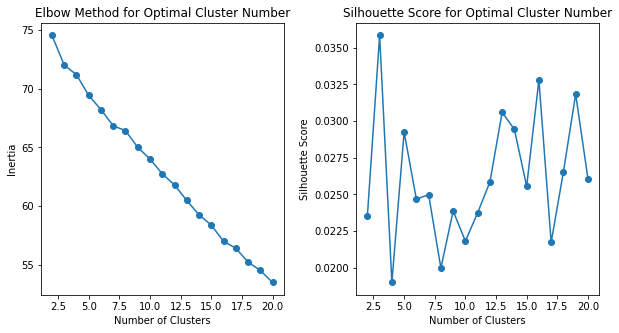

In [9]:
# Filter out the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Create a list to store the inertia (within-cluster sum of squares) and silhouette scores
inertia = []
silhouette_scores = []

# Define a range of cluster numbers to try
cluster_range = range(2, 21)

# Iterate through the range and fit KMeans for each cluster number
for n_cluster in cluster_range:
    km = KMeans(n_clusters=n_cluster)
    km.fit(tfidf_matrix)
    
    # Append the inertia score to the list
    inertia.append(km.inertia_)
    
    # Calculate the silhouette score
    if n_cluster > 1:
        silhouette_avg = silhouette_score(tfidf_matrix, km.labels_)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(None)

# Plot the elbow curve to find the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.subplots_adjust(wspace=0.3)

plt.show()


## K-Means Exploration and Similarity Distance

In previous sections, we explored K-Means clustering to group movies based on their plot summaries. However, we faced challenges in determining the optimal number of clusters. The Inertia and Silhouette Score methods did not yield distinct results, suggesting less-defined clusters.

Now, we'll delve into the concept of similarity distance between movie plot summaries. We'll use cosine similarity to measure how closely related movies are based on their content and meaning. This approach provides new insights into the relationships between movies, beyond traditional clustering.

This exploration will reveal hidden connections and patterns within the dataset, enhancing our understanding of the movies' content similarities.

In [10]:
# Import cosine_similarity to calculate similarity of movie plots
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

similarity_distance.shape, tfidf_matrix.shape

((100, 100), (100, 564))

## Visualizing Movie Similarity with Dendrograms

We'll now create a dendrogram, a tree-like diagram, to visually understand the level of similarity between movie titles. Dendrograms help us visualize the results of hierarchical clustering, which is an alternative to k-means clustering. The similarity between movie pairs is represented by the distance between their linkage points on the y-axis. Movies that share a lower linkage point are more similar in their plots. For example, the lowest linkage in our dendrogram may indicate that movies like "It's a Wonderful Life" and "A Place in the Sun" have very similar plots.


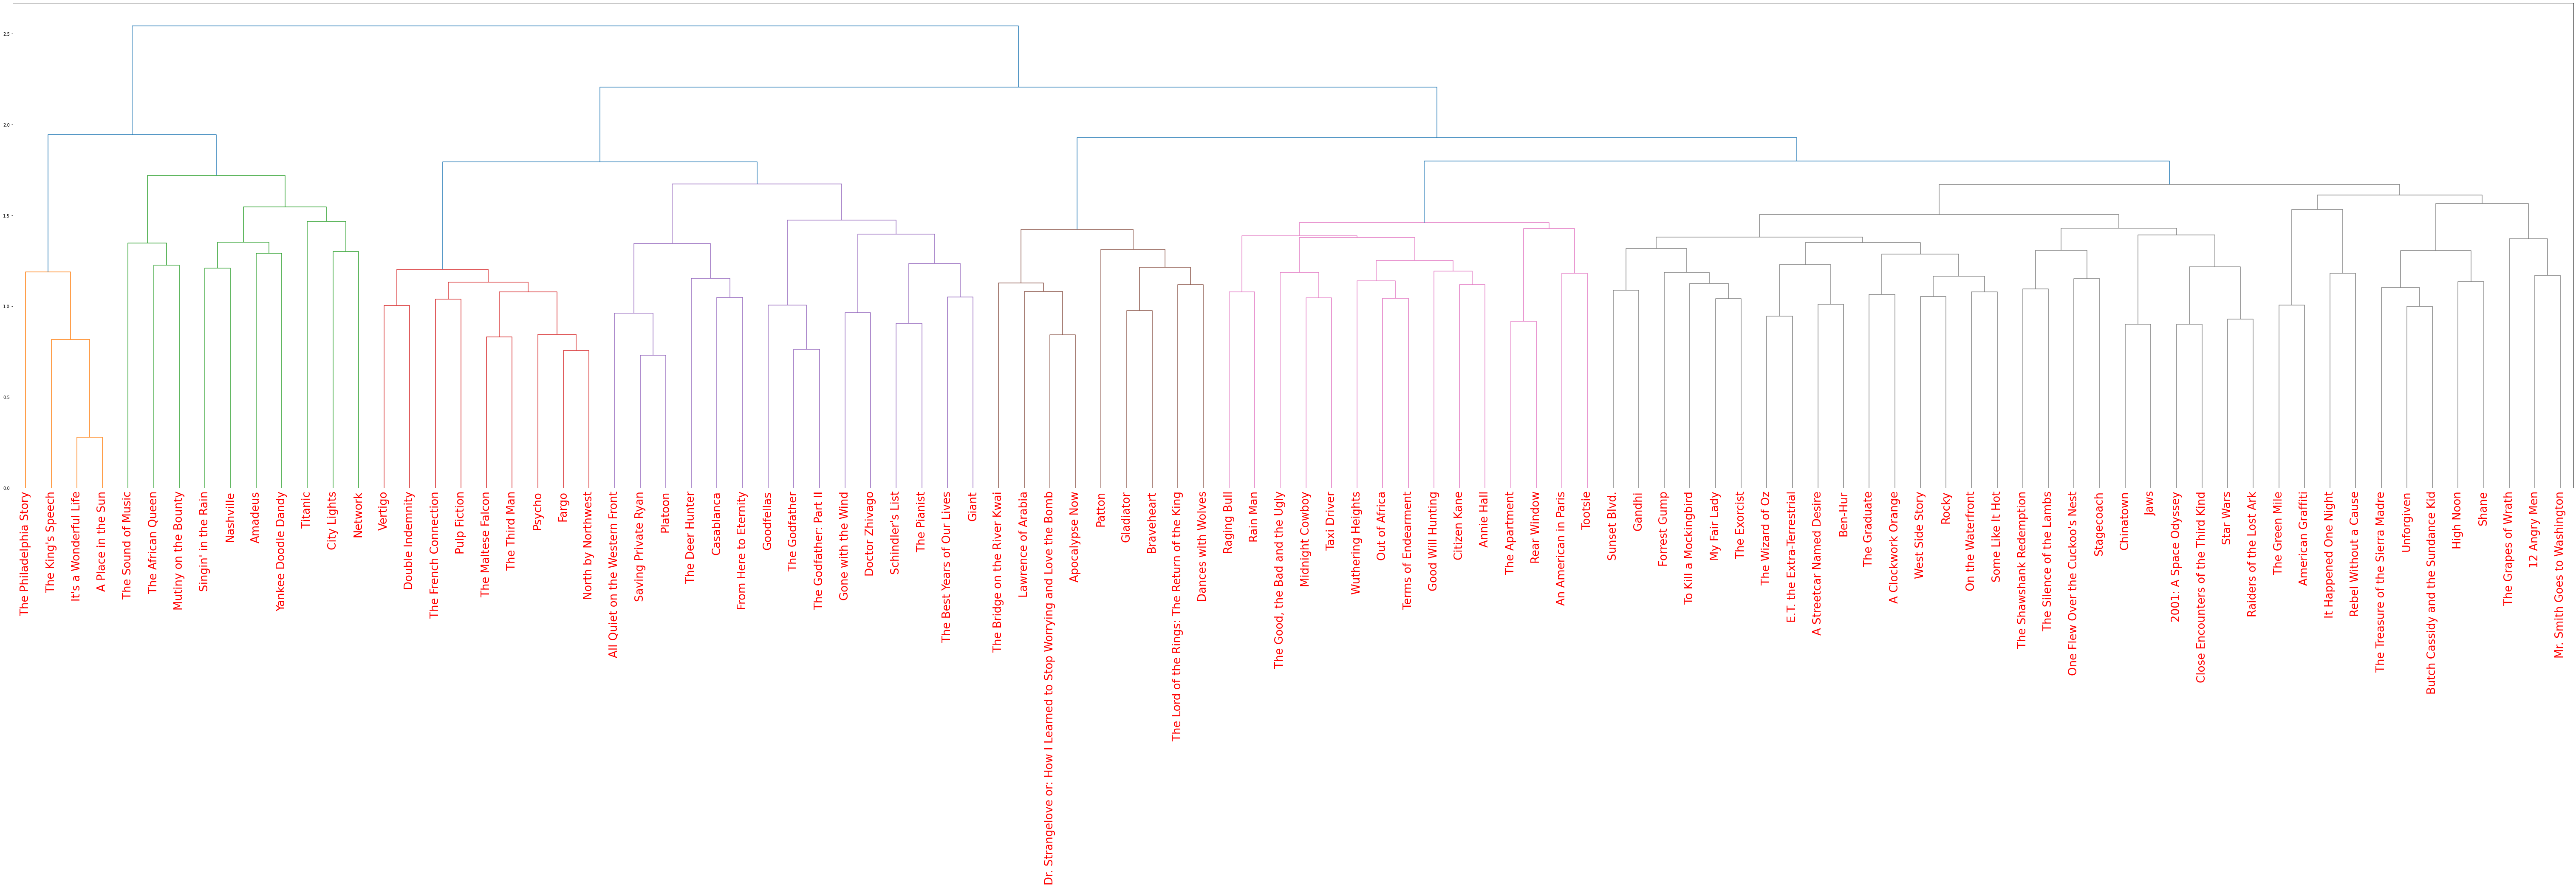

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies_df["title"]],
               leaf_rotation=90,
               leaf_font_size=26
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

plt.show()

## Dendrogram Clustering Summary

The dendrogram we created offers an opportunity to explore movie clusters. Based on this dendrogram, we can take several actions:

1. **Threshold-Based Clustering:** We can identify clusters by setting a similarity threshold. Movies with similarity values above this threshold can be grouped together. This allows us to create recommendations or analyze specific clusters of movies with strong plot similarities.

2. **In-Depth Cluster Analysis:** By examining different branches and heights on the dendrogram, we can gain insights into the hierarchical structure of clusters. This exploration helps us understand how movies are connected at various similarity levels.

3. **Refine Recommendation Systems:** Dendrograms provide valuable insights for improving recommendation systems. We can enhance user experiences by suggesting movies based on their similarity to other films within the same cluster.

Overall, the dendrogram is a powerful tool for understanding movie plot similarities and optimizing movie-related applications.


## Project Summary and Future Directions


In this project, we delved into the realm of movie similarity analysis using natural language processing and unsupervised learning. We began by merging plot summaries from IMDb and Wikipedia into a single source for streamlined analysis.

Through tokenization, stemming, and TF-IDF vectorization, we transformed textual data into a numerical format. Leveraging K-Means clustering, we grouped movies based on their plot summaries, revealing hidden relationships between films. We also explored similarity distance with cosine similarity, uncovering deeper connections among movies beyond traditional clustering.

To visualize these connections, we crafted dendrograms, offering fresh insights into the closeness of movie plots. This approach provided a unique perspective on movie content similarities, enhancing our clustering results.

**Next Steps:**

1. **Incorporate Additional Metadata:** Enhance analysis by including more metadata like movie release year, directors, and actors for deeper insights.

2. **Build a Recommendation System:** Use the generated clusters to develop a movie recommendation system for users with similar preferences.

3. **Text Data Refinement:** Improve text preprocessing and feature extraction methods for more accurate similarity calculations.

4. **Visualize Clusters:** Create visualizations to display the clustering results and identify distinctive patterns among movies.

5. **User Feedback Integration:** Incorporate user feedback and ratings to enhance the recommendation system's personalization.

This project provides a foundation for exploring movie-related data and implementing advanced recommendation systems in the future.
